In [29]:
domain = "https://www.tatianaphotos.com"
start_url = "https://www.tatianaphotos.com"

In [30]:
import time
import os
from urllib.parse import urlparse, urljoin
from collections import deque
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup

# Selenium setup
options = Options()
options.add_argument("--headless")
options.add_argument("--disable-gpu")
service = Service(ChromeDriverManager().install())
driver = webdriver.Chrome(service=service, options=options)

# Function to get the hyperlinks from a URL using Selenium
def get_hyperlinks(url):
    print(f"Getting hyperlinks for URL: {url}")
    try:
        driver.get(url)
        time.sleep(3)  # Adjust wait time as needed based on page load speed
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        hyperlinks = [a['href'] for a in soup.find_all('a', href=True)]
        return hyperlinks
    except Exception as e:
        print(f"Error getting hyperlinks: {e}")
        return []

# Function to crawl the website
def crawl(url):
    local_domain = urlparse(domain).netloc
    queue = deque([url])
    seen = {url}

    # Create necessary directories if they don't exist
    if not os.path.exists("text/"):
        os.mkdir("text/")
    if not os.path.exists(f"text/{local_domain}/"):
        os.mkdir(f"text/{local_domain}/")
    if not os.path.exists("processed"):
        os.mkdir("processed")

    while queue:
        url = queue.popleft()  # Use popleft to ensure we process URLs in a breadth-first manner
        print(f"Crawling URL: {url}")
        try:
            # Construct file path for saving content
            file_path = f"text/{local_domain}/{url[8:].replace('/', '_')}.txt"
            with open(file_path, "w") as f:
                driver.get(url)
                time.sleep(3)  # Adjust wait time as needed based on page load speed
                soup = BeautifulSoup(driver.page_source, "html.parser")
                text = soup.get_text()
                if "You need to enable JavaScript to run this app." in text:
                    print(f"Unable to parse page {url} due to JavaScript being required")
                f.write(text)
                # print(f"Writing: {text}")
        except Exception as e:
            print(f"Error crawling URL: {e}")

        try:
            for link in get_domain_hyperlinks(local_domain, url):
                if link not in seen:
                    queue.append(link)
                    seen.add(link)
        except Exception as e:
            print(f"Error processing links: {e}")

# Function to get the hyperlinks from a URL that are within the same domain and base URL
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    hyperlinks = get_hyperlinks(url)
    print(f"Found {len(hyperlinks)} hyperlinks on {url}")
    for link in set(hyperlinks):
        clean_link = None
        print(f"Checking link: {link}")
        
        # Handle absolute URLs
        if link.startswith("http"):
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain and link.startswith(domain):
                clean_link = link
        else:
            # Handle relative URLs
            clean_link = urljoin(url, link)

        if clean_link is not None and '@' not in clean_link and clean_link not in clean_links:
            print(f"Adding clean link: {clean_link}")
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    print(f"Clean links: {clean_links}")
    return list(set(clean_links))

# Start crawling from the base URL
crawl(start_url)

driver.quit()


Crawling URL: https://www.grainger.com/category/tools/power-tools/cordless-tool-combination-kits?brandName=DEWALT~QP&webParentSkuKey=WP7964084%7CWP7964086&filters=brandName%2CwebParentSkuKey&searchQuery=Dewalt+tools&sst=4&ts_optout=true
Getting hyperlinks for URL: https://www.grainger.com/category/tools/power-tools/cordless-tool-combination-kits?brandName=DEWALT~QP&webParentSkuKey=WP7964084%7CWP7964086&filters=brandName%2CwebParentSkuKey&searchQuery=Dewalt+tools&sst=4&ts_optout=true
Found 1 hyperlinks on https://www.grainger.com/category/tools/power-tools/cordless-tool-combination-kits?brandName=DEWALT~QP&webParentSkuKey=WP7964084%7CWP7964086&filters=brandName%2CwebParentSkuKey&searchQuery=Dewalt+tools&sst=4&ts_optout=true
Checking link: /
Adding clean link: https://www.grainger.com/
Clean links: ['https://www.grainger.com']
Crawling URL: https://www.grainger.com
Getting hyperlinks for URL: https://www.grainger.com
Found 1 hyperlinks on https://www.grainger.com
Checking link: /
Adding 

In [31]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [32]:
import pandas as pd
import os

# Create a list to store the text files
texts=[]

domain_dir = os.path.join("text", domain)
abs_domain_dir = os.path.abspath(domain_dir)

if os.path.exists(abs_domain_dir):
    # Get all the text files in the text directory
    for file in os.listdir("text/" + domain + "/"):
        
        try:
            # Open the file and read the text
            with open("text/" + domain + "/" + file, "r") as f:
                text = f.read()
        
                # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
                texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))
        except Exception as e:
            print(f"Exception occurred during reading file '{text}': {e}")       
else:
    print(f"Directory '{abs_domain_dir}' does not exist.")
# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

Directory '/Users/noel_niko/PycharmProjects/graigner_recommendations_chatbot/text/https:/www.grainger.com' does not exist.


/var/folders/_x/sgylm_cs37zg8cfcxk6076bh0000gn/T/ipykernel_4878/2966875972.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text


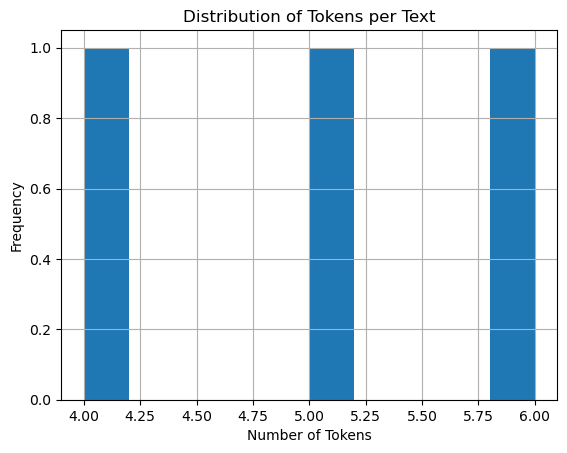

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer

# Assuming your dataframe 'df' is already created and contains a 'text' column
df = pd.DataFrame({
    'text': ["This is a sample text.", "Another example text.", "Yet another text sample."]
})

# Initialize the tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

# Calculate the number of tokens for each text
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Distribution of Tokens per Text')
plt.show()
